In [1]:
import pandas as pd
import numpy as np
import json
import datetime

In [2]:
businesses = []
for line in open('../../../data/yelp_dataset_2022/business.json', 'r'):
    businesses.append(json.loads(line))

In [3]:
# Get businesses to DF and remove those without categories, can't tell what type of business
business_df = pd.DataFrame(businesses)

business_df = business_df[~business_df['categories'].isna()]

# Spit categories from a string into a list
business_df['categories'] = business_df['categories'].apply(lambda x: [cat.strip() for cat in x.split(",")])

In [4]:
# Filter the categories column to the list of categories
def category_filter(df, categories):
    return df[df['categories'].map(set(categories).issubset)]

In [5]:
# Get min and max by group
def review_group_stats(df, col):
    review_stats = df.groupby(col).agg(
                        Min=('stars',np.min),
                        Max=('stars',np.max),
                        Mean=('stars',np.mean))
    return review_stats

In [6]:
# Normalize the star ratings to be ratio of average in group
def normalize_stars(df, col):
    stats_df = review_group_stats(df, col)
    merged_df = df.join(stats_df, on=col)
    #merged_df['norm_stars'] = np.where(merged_df['Min'] == merged_df['Max'],
    #                                   0.5,
    #                                   (merged_df['stars'] - merged_df['Min'])/(merged_df['Max'] - merged_df['Min']))
    merged_df['norm_stars'] = merged_df['stars'] / merged_df['Mean']
    return merged_df

In [7]:
# Filter to Chinese Restaurants
chinese_rest_df = category_filter(business_df, ['Chinese','Restaurants'])

# Normalize the stars by state
norm_stars = normalize_stars(chinese_rest_df, 'state')

<AxesSubplot:>

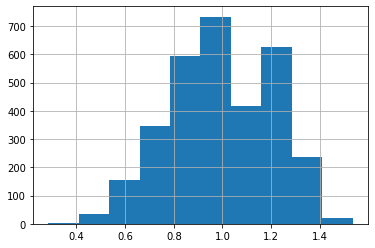

In [10]:
norm_stars['norm_stars'].hist()

In [11]:
norm_stars.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,Min,Max,Mean,norm_stars
45,wghnIlMb_i5U46HMBGx9ig,China Dragon Restaurant,"1625 W Valencia Rd, Ste 101-103",Tucson,AZ,85746,32.132305,-110.999985,3.0,23,0,"{'WiFi': ''no'', 'BusinessParking': '{'garage'...","[Restaurants, Chinese]","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",1.5,4.5,3.325000,0.902256
130,3BJxm-HnvzdwD1zjmSbmyQ,Golden Chopstick Chinese Restaurant,1800 Spring Garden St,Philadelphia,PA,19130,39.963078,-75.168027,3.0,137,1,"{'GoodForKids': 'True', 'RestaurantsDelivery':...","[Restaurants, Chinese]","{'Monday': '0:0-0:0', 'Tuesday': '11:0-22:30',...",1.5,5.0,3.416667,0.878049
200,vPcfJ3rm3NpdqVDod2WxLA,China Pearl,2E Summit Sq Shopping Ctr,Langhorne,PA,19047,40.217784,-74.926586,1.5,27,1,"{'OutdoorSeating': 'False', 'RestaurantsDelive...","[Japanese, Chinese, Restaurants, Thai]","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",1.5,5.0,3.416667,0.439024
249,bqmX882_6AxVA_uHEQ70sQ,Shanghai Station,4002 Spruce St,Philadelphia,PA,19104,39.951615,-75.203346,4.0,46,0,"{'Caters': 'False', 'BikeParking': 'False', 'R...","[Shanghainese, Restaurants, Sushi Bars, Szechu...",None,1.5,5.0,3.416667,1.170732
271,jcL_qaGJiappzpnn-ifSoA,Fat Jakks,10126 - 107 Avenue NW,Edmonton,AB,T5H 0V6,53.551551,-113.495155,4.0,8,0,"{'RestaurantsDelivery': 'True', 'RestaurantsPr...","[Chinese, Restaurants, Filipino]",None,1.5,5.0,3.440594,1.162590


In [12]:
# Helper function for pandas apply, check if the restaurant has an attribute
def has_attribute(attr_dict,attr):
    if attr_dict is None:
        return False
    else:
        return attr_dict.get(attr,False) == 'True'

In [13]:
# Create boolean column for if the restaurants have attribute
def get_attribute(df, attribute):
    df[attribute] = df['attributes'].apply(has_attribute, attr=attribute)
    return df

In [14]:
norm_stars = get_attribute(norm_stars, 'RestaurantsDelivery')
norm_stars = get_attribute(norm_stars, 'RestaurantsTakeOut')

In [15]:
reviews = []
for line in open('../../../data/yelp_dataset_2022/review.json', 'r'):
    reviews.append(json.loads(line))

reviews_df = pd.DataFrame(reviews)

In [17]:
reviews_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5.0,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3.0,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [18]:
# Filter to only Chinese Restaurants
chinese_rest_reviews = reviews_df[reviews_df['business_id'].isin(norm_stars['business_id'].values)]

# Join the business attributes to each of the reviews
chinese_rest_reviews = chinese_rest_reviews.merge(norm_stars[['business_id','norm_stars','RestaurantsDelivery','RestaurantsTakeOut','Mean']], on='business_id')

chinese_rest_reviews['review_norm_stars'] = chinese_rest_reviews['stars'] / chinese_rest_reviews['Mean']

In [19]:
# Create column to group by year and month
chinese_rest_reviews['year'] = pd.DatetimeIndex(chinese_rest_reviews['date']).year
chinese_rest_reviews['month'] = pd.DatetimeIndex(chinese_rest_reviews['date']).month

chinese_rest_reviews['year_month'] = chinese_rest_reviews.year*10000 + chinese_rest_reviews.month*100 + 1

chinese_rest_reviews['year_month'] = pd.to_datetime(chinese_rest_reviews['year_month'], format='%Y%m%d')

# Find average rating for each category by year-month
mean_delivery = chinese_rest_reviews.groupby(['year_month','RestaurantsDelivery']).mean().reset_index()
mean_takeout = chinese_rest_reviews.groupby(['year_month','RestaurantsTakeOut']).mean().reset_index()

In [20]:
import matplotlib.pyplot as plt

In [22]:
mean_delivery_post_2019 = mean_delivery[(mean_delivery['year'] >= 2019) & mean_delivery['RestaurantsDelivery']]
mean_nodelivery_post_2019 = mean_delivery[(mean_delivery['year'] >= 2019) & (mean_delivery['RestaurantsDelivery']==False)]

mean_takeout_post_2019 = mean_takeout[(mean_takeout['year'] >= 2019) & mean_takeout['RestaurantsTakeOut']]
mean_notakeout_post_2019 = mean_takeout[(mean_takeout['year'] >= 2019) & (mean_takeout['RestaurantsTakeOut']==False)]

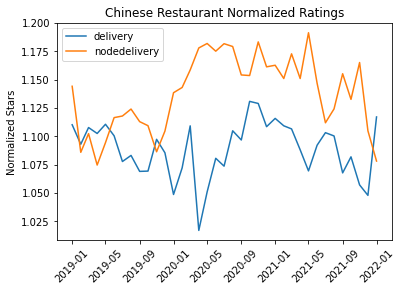

In [23]:
plt.plot(mean_delivery_post_2019['year_month'],mean_delivery_post_2019['review_norm_stars'], label="delivery")
plt.plot(mean_nodelivery_post_2019['year_month'],mean_nodelivery_post_2019['review_norm_stars'], label='nodedelivery')
plt.ylabel("Normalized Stars")
plt.xticks(rotation = 45)
plt.title("Chinese Restaurant Normalized Ratings")
plt.legend()

In [ ]:
plt.plot(mean_takeout_post_2019['year_month'],mean_takeout_post_2019['norm_stars'], label="TakeOut")
plt.plot(mean_notakeout_post_2019['year_month'],mean_notakeout_post_2019['norm_stars'], label="No TakeOut")
plt.legend()
_ = plt.ylabel("Normalized Stars")
_ = plt.title("Chinese Restaurant Normalized Ratings")
_ = plt.xticks(rotation = 45)

In [ ]:
chinese_rest_reviews.to_csv("../../../data/chinese_restaurants_reviews.csv",index=False)